In [1]:
import os

import torch

from src.agents import ContinuosActorCritic
from src.networks import ActorCriticNetwork
from src.pv_env import History, PVEnv
from src.reward import RewardDeltaPower

PV_PARAMS_PATH = os.path.join("parameters", "01_pvarray.json")
WEATHER_TRAIN_PATH = os.path.join("data", "weather_sim.csv")
WEATHER_TEST_PATH = os.path.join("data", "weather_real.csv")
PVARRAY_CKP_PATH = os.path.join('data', '01_pvarray_iv.json')
AGENT_CKP_PATH = os.path.join("models", "02_mppt_ac.tar")
LEARNING_RATE = 0.00001
ENTROPY_BETA = 0.001
GAMMA = 0.9
N_STEPS = 1
BATCH_SIZE = 16

In [2]:
env = PVEnv.from_file(
    PV_PARAMS_PATH,
    WEATHER_TRAIN_PATH,
    pvarray_ckp_path=PVARRAY_CKP_PATH,
    states=["v_norm", "i_norm", "deg"],
    reward_fn=RewardDeltaPower(1, 0.9),
)
test_env = PVEnv.from_file(
    PV_PARAMS_PATH,
    WEATHER_TRAIN_PATH,
    pvarray_ckp_path=PVARRAY_CKP_PATH,
    states=["v_norm", "i_norm", "deg"],
    reward_fn=RewardDeltaPower(1, 0.9),
)
device = torch.device("cpu")
net = ActorCriticNetwork(
    input_size=env.observation_space.shape[0],
    n_actions=env.action_space.shape[0]
).to(device)
agent = ContinuosActorCritic(
    env=env,
    test_env=test_env,
    net=net,
    device=device,
    gamma=GAMMA,
    beta_entropy=ENTROPY_BETA,
    lr=LEARNING_RATE,
    n_steps=N_STEPS,
    batch_size=BATCH_SIZE,
    # chk_path=AGENT_CKP_PATH,
    chk_path=None,
)

INFO 2020-11-18 10:56:25,518 Dictionary readed from parameters\01_pvarray.json
INFO 2020-11-18 10:56:25,519 Starting MATLAB engine . . .
INFO 2020-11-18 10:56:31,725 MATLAB engine initializated.
INFO 2020-11-18 10:56:52,082 Model loaded succesfully.
INFO 2020-11-18 10:56:52,112 Dictionary readed from data\01_pvarray_iv.json
INFO 2020-11-18 10:56:52,115 Reading data\weather_sim.csv . . .
INFO 2020-11-18 10:56:52,125 Dictionary readed from parameters\01_pvarray.json
INFO 2020-11-18 10:56:52,126 Starting MATLAB engine . . .
INFO 2020-11-18 10:56:58,361 MATLAB engine initializated.
INFO 2020-11-18 10:57:18,346 Model loaded succesfully.
INFO 2020-11-18 10:57:18,370 Dictionary readed from data\01_pvarray_iv.json
INFO 2020-11-18 10:57:18,372 Reading data\weather_sim.csv . . .


In [25]:
agent.learn(steps=10000, verbose_every=100, save_every=0)

  1%|          | 106/10000 [00:02<04:00, 41.06it/s]
 7900: loss=0.488842,  mean reward=-414.64,  steps/ep=1319,  episodes=150
  2%|▏         | 206/10000 [00:05<03:48, 42.80it/s]
 8000: loss=0.673561,  mean reward=-424.42,  steps/ep=833,  episodes=152
  3%|▎         | 305/10000 [00:07<03:52, 41.69it/s]
 8100: loss=0.477342,  mean reward=-437.01,  steps/ep=833,  episodes=154
  4%|▍         | 405/10000 [00:10<04:14, 37.72it/s]
 8200: loss=0.498824,  mean reward=-447.06,  steps/ep=833,  episodes=156
  5%|▌         | 502/10000 [00:12<05:14, 30.20it/s]
 8300: loss=0.304679,  mean reward=-457.97,  steps/ep=833,  episodes=158
  6%|▌         | 606/10000 [00:15<04:18, 36.34it/s]
 8400: loss=0.436229,  mean reward=-468.57,  steps/ep=833,  episodes=160
  7%|▋         | 707/10000 [00:18<03:39, 42.38it/s]
 8500: loss=0.206960,  mean reward=-482.62,  steps/ep=833,  episodes=162
  8%|▊         | 804/10000 [00:20<03:40, 41.71it/s]
 8600: loss=0.349513,  mean reward=-496.49,  steps/ep=833,  episodes=164

KeyboardInterrupt: 

INFO 2020-11-18 11:05:29,412 Calculating true MPP . . .
Calculating true MPP: 100%|##########| 834/834 [00:01<00:00, 747.93it/s]
INFO 2020-11-18 11:05:30,529 Running P&O, step=0.2 volts . . .
Calculating PO: 100%|##########| 834/834 [00:00<00:00, 208515.11it/s]


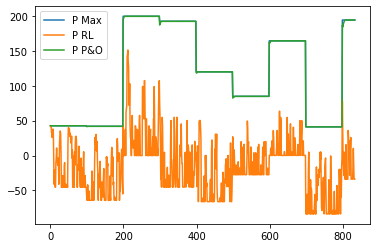

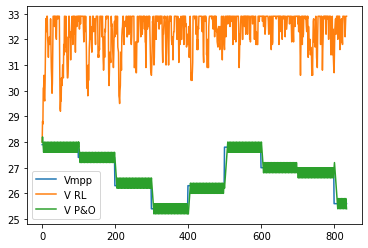

INFO 2020-11-18 11:05:31,169 PO Efficiency=99.87892064901877
INFO 2020-11-18 11:05:31,170 RL Efficiency=-34.544390406285515


In [26]:
agent.exp_train_source.play_episode()
env.render_vs_true(po=True)

INFO 2020-11-18 11:05:34,962 Calculating true MPP . . .
Calculating true MPP: 100%|##########| 834/834 [00:01<00:00, 814.39it/s]
INFO 2020-11-18 11:05:35,989 Running P&O, step=0.2 volts . . .
Calculating PO: 100%|##########| 834/834 [00:00<00:00, 208527.54it/s]


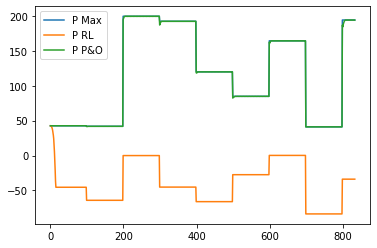

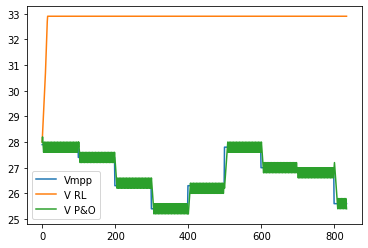

INFO 2020-11-18 11:05:36,556 PO Efficiency=99.87892064901877
INFO 2020-11-18 11:05:36,557 RL Efficiency=-66.60082891491142


In [27]:
agent.exp_test_source.play_episode()
test_env.render_vs_true(po=True)

In [18]:
obs = env.reset()
agent.policy(obs), agent.test_policy(obs), agent.net(torch.tensor(obs, dtype=torch.float32))

(-1.7703127,
 -0.065317616,
 (tensor([-0.0653], grad_fn=<TanhBackward>),
  tensor([0.6805], grad_fn=<SoftplusBackward>),
  tensor([-0.0109], grad_fn=<AddBackward0>)))

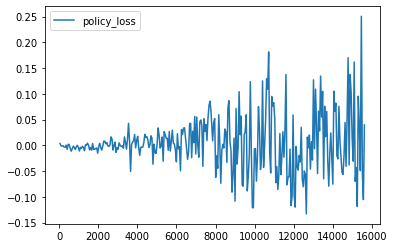

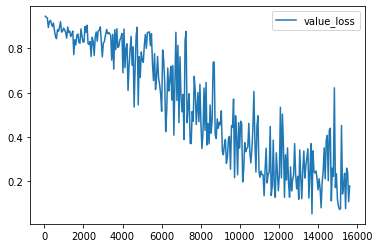

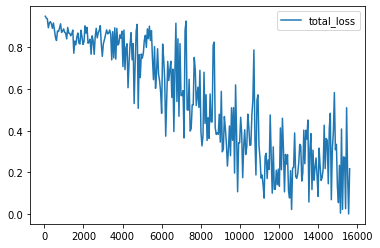

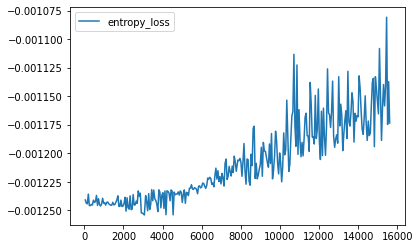

In [28]:
agent.plot_performance(['policy_loss', 'value_loss', 'total_loss', 'entropy_loss'])

In [29]:
agent.net

ActorCriticNetwork(
  (base1): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
  )
  (base2): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
  )
  (base3): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
  )
  (mean): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Tanh()
  )
  (var): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Softplus(beta=1, threshold=20)
  )
  (value): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
)